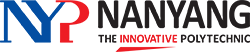

# IT2311 Assignment - Task 1b: Topic Modelling

Complete the following sub-tasks:
1.	**Load Data**: Load the clean dataset
2.	**Data Preparation**: Prepares the text representation for this task
3.	**Modelling**: Perform topic modelling and identify the suitable topic number
4.	**Evaluation**: Evaluates the results and identify the topic

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in the Jupyter notebook**. 

**Done by: Tia Isabel Solanki 220829L**

## Import libraries and download the packages

In [1]:
# Data Manipulation
import pandas as pd  

# Text Preprocessing and Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer  
import nltk  
from nltk.util import ngrams  

# Topic Modeling
from gensim.models.ldamodel import LdaModel  
from gensim import corpora  
from gensim.models.coherencemodel import CoherenceModel  
from gensim.corpora import Dictionary  

# Clustering and Dimensionality Reduction
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans  

# Visualization
import matplotlib.pyplot as plt  
from wordcloud import WordCloud  

# Utilities
from collections import Counter  
from pprint import pprint  
import random  
import scipy.sparse as sp  

# NLP Processing
import spacy  
nlp = spacy.load("en_core_web_sm")  

# Additional Imports
import pyLDAvis
import pyLDAvis.gensim_models  
from IPython.core.display import display

C:\Users\solan\AppData\Local\Temp\ipykernel_18972\4181546955.py:36: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


## Load Data

In [2]:
df = pd.read_csv('cleaned_text.csv')
df.head()

,tokens,cleaned_text
0,"['improve', 'quality', 'safety', 'care', 'oppo...",improve quality safety care opportunity backgr...
1,"['emergency', 'relief', 'education', 'infrastr...",emergency relief education infrastructure comm...
2,"['support', 'philanthropy', 'child', 'empowerm...",support philanthropy child empowerment nutriti...
3,"['provision', 'clinical', 'trial', 'reduce', '...",provision clinical trial reduce inequity pregn...
4,"['provision', 'strategic', 'action', 'support'...",provision strategic action support large scale...


In [3]:
# Remove any empty rows in case
df = df.dropna(subset=['cleaned_text'])

## Data Preparation
Perform the necessary steps and explain the rationale taken here.



As we want to find the best Topic Models based on Perplexity, Coherence and Interpretibility, and Quality of Topics, we will be testing and creating our Topic Models using both doc term Matrix and TFIDF to see gives us better results.

### Create Gensim Dictionary and Document-Term Matrix (for doc2bow)

The code tokenizes the data from the cleaned_text column so each column has a list of words. A Gensim Dictionary is created from this tokenized data. A unique integer ID is assigned to each word in the corpus and tracks the frequecies of the words and help to put it into a numerical representation of the text. 

Doc-Term Matrix uses the doc2bow method. It converts each doc into a bag-of-words list - (word_id, word_count) tuples which captures the frequency of each word.

In [4]:
# Preprocess the text data
doc_clean = [text.split() for text in df['cleaned_text']]

# Create a Gensim Dictionary
dictionary = Dictionary(doc_clean)

# Create a Document-Term Matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

### Vectorize Using TfidfVectorizer (for tfidf_matrix)

Here, it's doing the same thing as above but using TF-IDF Vectorization method and prepares it for analysis with Gensim. Tfidf Vectorizer is applied to transform the cleaned_text column into a TF-IDF Matrix. It represents the importance of each word relative to the document and the entire corpus.get_feature_names_out method retrieves, the unique tokens from the vectorized data. The TF-IDF matrix is converted into Sparse2Corpus format so Gensim can recognise it and a Gensim Dictionary is created from the TFIDF tokens. It assigns unique IDs to the words just like the doc2bow method. 

In [5]:
# Vectorize using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [6]:
import gensim
from gensim import matutils

# Convert Tfidf matrix to Gensim's Document-Term Matrix
tfidf_tokens = tfidf_vectorizer.get_feature_names_out()
corpus_tfidf = gensim.matutils.Sparse2Corpus(tfidf_matrix, documents_columns=False)

In [7]:
# Create a Gensim Dictionary from the Tfidf tokens
dictionary_tfidf = Dictionary([tfidf_tokens])

Now tokens are converted into a format ready to be fed into the Model.

## Modelling
Perform the necessary steps and explain the rationale taken here.



### Build LDA Model

My chosen method of Modelling will be LDA (Latent Dirichlet Allocation) because it can reveal the underlying topic structure in text data in a probabalistic and interpretable way.

This code is used to find the best models by using different numbers of topics and words. This allows the model to explore various combinations of parameters to determine which one provides the best results based on Perplexity and Coherence

I used both the Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF) to build the models and compare their performance in generating interpretable topics. The objective was to assess which approach yields more coherent (interpretable) topics and better overall model performance. The BoW model represents documents using raw term frequencies, while the TF-IDF model adjusts word frequencies by considering their rarity across the entire corpus, potentially highlighting more meaningful terms.

In [8]:
# Topic and word numbers to try
topic_num_list = [3, 5, 7, 9, 11]
word_num_list = [5, 10, 15]

# Empty DataFrame to store results
df_per_coherence = pd.DataFrame()

results = []

In [9]:
# Initialize an empty list to store results
results = []

# Define the lists of topic and word numbers
topic_num_list = [5, 10, 15, 20, 25, 30]
word_num_list = [5, 10, 15]

# Loop through topic and word numbers
for topic_num in topic_num_list:
    for word_num in word_num_list:
        print(f"Processing {topic_num} topics and {word_num} words...")

        # BoW LDA Model
        lda_bow = LdaModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary, passes=20)
        coherence_bow = CoherenceModel(model=lda_bow, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence()
        perplexity_bow = lda_bow.log_perplexity(doc_term_matrix)
        print(f"BoW Model - Topics: {topic_num}, Words: {word_num}, Coherence: {coherence_bow}, Perplexity: {perplexity_bow}")

        # TF-IDF LDA Model
        lda_tfidf = LdaModel(corpus_tfidf, num_topics=topic_num, id2word=dictionary_tfidf, passes=20)
        coherence_tfidf = CoherenceModel(model=lda_tfidf, texts=doc_clean, dictionary=dictionary_tfidf, coherence='c_v').get_coherence()
        perplexity_tfidf = lda_tfidf.log_perplexity(corpus_tfidf)
        print(f"TF-IDF Model - Topics: {topic_num}, Words: {word_num}, Coherence: {coherence_tfidf}, Perplexity: {perplexity_tfidf}")

        # Store results
        results.append({
            'Num_Topics': topic_num, 
            'Word_Num': word_num, 
            'Coherence_BoW': coherence_bow,
            'Perplexity_BoW': perplexity_bow,
            'Coherence_TFIDF': coherence_tfidf,
            'Perplexity_TFIDF': perplexity_tfidf
        })

Processing 5 topics and 5 words...
BoW Model - Topics: 5, Words: 5, Coherence: 0.44330033093527454, Perplexity: -7.327943102596471
TF-IDF Model - Topics: 5, Words: 5, Coherence: 0.33241835220770877, Perplexity: -9.251824279046476
Processing 5 topics and 10 words...
BoW Model - Topics: 5, Words: 10, Coherence: 0.4360545387988261, Perplexity: -7.331125062547736
TF-IDF Model - Topics: 5, Words: 10, Coherence: 0.40785943935019525, Perplexity: -9.214510361244718
Processing 5 topics and 15 words...
BoW Model - Topics: 5, Words: 15, Coherence: 0.43221793101803846, Perplexity: -7.323617575205158
TF-IDF Model - Topics: 5, Words: 15, Coherence: 0.4790332959166719, Perplexity: -9.222571375172224
Processing 10 topics and 5 words...
BoW Model - Topics: 10, Words: 5, Coherence: 0.48755989737971567, Perplexity: -7.305700590630737
TF-IDF Model - Topics: 10, Words: 5, Coherence: 0.5212017793752202, Perplexity: -9.848177437831954
Processing 10 topics and 10 words...
BoW Model - Topics: 10, Words: 10, Co

In [10]:
# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,Num_Topics,Word_Num,Coherence_BoW,Perplexity_BoW,Coherence_TFIDF,Perplexity_TFIDF
0,5,5,0.443300,-7.327943,0.332418,-9.251824
1,5,10,0.436055,-7.331125,0.407859,-9.214510
2,5,15,0.432218,-7.323618,0.479033,-9.222571
3,10,5,0.487560,-7.305701,0.521202,-9.848177
4,10,10,0.468511,-7.294319,0.549746,-9.806576
5,10,15,0.458345,-7.291071,0.540572,-9.912375
6,15,5,0.457844,-7.443992,0.553137,-11.100182
7,15,10,0.497872,-7.411623,0.592692,-11.053329
8,15,15,0.503917,-7.422310,0.575995,-11.151154
9,20,5,0.498909,-7.538061,0.608577,-12.259497


This output shows the Perplexity and Coherence of the different LDA models generated using the bag of words and TFIDF method based on different Perplexity and Coherence measures. We can see the TFIDF significantly produces better results than bow.

In this code before, we are doing tuning for mainly the no. of topics for just the bow method because i found the models are more meaningful with bow over tfidf.

In [11]:
# Initialize an empty DataFrame to store results
df_per = pd.DataFrame()

# Define the lists of topic and word numbers
topic_num_list = [5, 10, 15, 20, 25, 30]
word_num_list = [5, 10, 15]

# Loop through topic and word numbers
for topic_num in topic_num_list:
    for word_num in word_num_list:
        print(f"Processing {topic_num} topics and {word_num} words...")

        # BoW LDA Model
        lda_bow = LdaModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary, passes=20, per_word_topics=True)
        coherence_bow = CoherenceModel(model=lda_bow, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence()
        perplexity_bow = lda_bow.log_perplexity(doc_term_matrix)

        print(f"BoW Model - Topics: {topic_num}, Words: {word_num}, Coherence: {coherence_bow}, Perplexity: {perplexity_bow}")

        # Store results in a DataFrame
        df_temp = pd.DataFrame({'Num_Topics': topic_num, 'Word_Num': word_num, 
                                'Coherence_BoW': coherence_bow, 'Perplexity_BoW': perplexity_bow}, index=[0])
        df_per = pd.concat([df_temp, df_per])

# Reset index for final DataFrame
df_per = df_per.reset_index(drop=True)
df_per.head()

Processing 5 topics and 5 words...
BoW Model - Topics: 5, Words: 5, Coherence: 0.39807585409565704, Perplexity: -7.316785082437797
Processing 5 topics and 10 words...
BoW Model - Topics: 5, Words: 10, Coherence: 0.4508474648695463, Perplexity: -7.325932858109229
Processing 5 topics and 15 words...
BoW Model - Topics: 5, Words: 15, Coherence: 0.42294349580586915, Perplexity: -7.323711421553454
Processing 10 topics and 5 words...
BoW Model - Topics: 10, Words: 5, Coherence: 0.5070563773263155, Perplexity: -7.280328017909538
Processing 10 topics and 10 words...
BoW Model - Topics: 10, Words: 10, Coherence: 0.4577916108021104, Perplexity: -7.2931685736821565
Processing 10 topics and 15 words...
BoW Model - Topics: 10, Words: 15, Coherence: 0.4742808859500104, Perplexity: -7.288795487323154
Processing 15 topics and 5 words...
BoW Model - Topics: 15, Words: 5, Coherence: 0.45071225214880833, Perplexity: -7.43767921312568
Processing 15 topics and 10 words...
BoW Model - Topics: 15, Words: 10,

,Num_Topics,Word_Num,Coherence_BoW,Perplexity_BoW
0,30,15,0.495253,-7.729620
1,30,10,0.495593,-7.727887
2,30,5,0.512252,-7.711133
3,25,15,0.517215,-7.631105
4,25,10,0.524748,-7.644313


This output  the Perplexity and Coherence of the different LDA models generated using the bag of words method based on different Perplexity and Coherence measures. 

In [12]:
df_per_sorted = df_per.sort_values(by='Word_Num', ascending=True)
df_per_sorted

,Num_Topics,Word_Num,Coherence_BoW,Perplexity_BoW
8,20,5,0.460794,-7.559755
14,10,5,0.507056,-7.280328
11,15,5,0.450712,-7.437679
5,25,5,0.482477,-7.639696
17,5,5,0.398076,-7.316785
2,30,5,0.512252,-7.711133
7,20,10,0.474336,-7.541125
16,5,10,0.450847,-7.325933
10,15,10,0.488077,-7.419707
13,10,10,0.457792,-7.293169


In [13]:
df_top_coherence = df_per.nlargest(5, 'Coherence_BoW')
print("Top 5 Rows by Coherence Score:")
df_top_coherence

Top 5 Rows by Coherence Score:


,Num_Topics,Word_Num,Coherence_BoW,Perplexity_BoW
4,25,10,0.524748,-7.644313
3,25,15,0.517215,-7.631105
2,30,5,0.512252,-7.711133
14,10,5,0.507056,-7.280328
6,20,15,0.504830,-7.540396


In [14]:
df_top_perplexity = df_per.nsmallest(5, 'Perplexity_BoW')
print("Top 5 Rows by Lowest Perplexity Score:")
df_top_perplexity

Top 5 Rows by Lowest Perplexity Score:


,Num_Topics,Word_Num,Coherence_BoW,Perplexity_BoW
0,30,15,0.495253,-7.729620
1,30,10,0.495593,-7.727887
2,30,5,0.512252,-7.711133
4,25,10,0.524748,-7.644313
5,25,5,0.482477,-7.639696


We can compare the coherence and perplexity scores for both the Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF) models across different numbers of topics and word counts. The coherence score measures the interpretability of the topics, with higher values indicating more meaningful topics, while perplexity evaluates how well the model generalizes to unseen data, with lower values being preferred. The code generates two separate plots: one for coherence scores and one for perplexity scores, allowing for a clear comparison of how each model performs under different configurations. By plotting these scores, we gain insights into the impact of varying the number of topics and word counts, so we can select the model that offers the best balance.

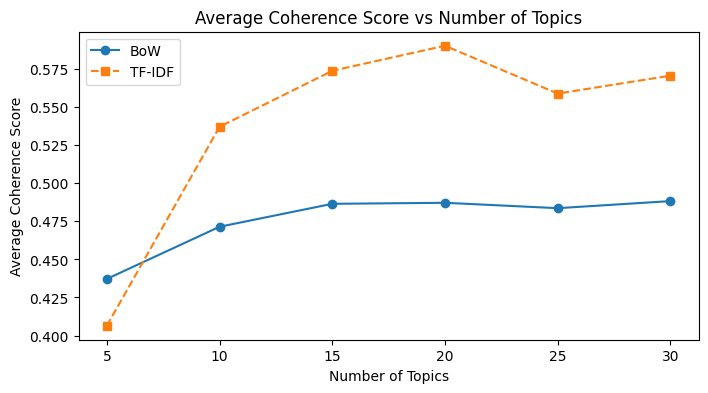

In [66]:
import matplotlib.pyplot as plt

# Calculate the average coherence score for each number of topics
df_avg_coherence = df_results.groupby('Num_Topics').agg({
    'Coherence_BoW': 'mean', 
    'Coherence_TFIDF': 'mean'
}).reset_index()

# Plot Coherence Scores (average for each number of topics)
plt.figure(figsize=(8, 4))

# Plotting for BoW and TF-IDF, using the average values
plt.plot(df_avg_coherence['Num_Topics'], df_avg_coherence['Coherence_BoW'], marker='o', linestyle='-', label='BoW')
plt.plot(df_avg_coherence['Num_Topics'], df_avg_coherence['Coherence_TFIDF'], marker='s', linestyle='--', label='TF-IDF')

# Labeling the axes and title
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Average Coherence Score vs Number of Topics')

# Add a legend
plt.legend()

# Display the plot
plt.show()


The "Average Coherence Score vs. Number of Topics" graph contrasts the effectiveness of two models: Term Frequency-Inverse Document Frequency (TF-IDF) and Bag of Words (BoW) over a range of topics from 5 to 30. The coherence ratings of the TF-IDF model are consistently greater than those of the BoW model. In particular, the coherence score of the TF-IDF model peaks at about 0.58 for 20 topics, falls somewhat but stays over 0.570 for 30 topics, and begins at about 0.400 for 5 topics. The BoW model, on the other hand, begins at around 0.425 for five subjects, rises to about 0.475 for 15 topics, and then stays comparatively steady at 0.475 for more topics. According to this, the TF-IDF model is better at generating subjects that make sense when compared to bow model, when topic num increases.

However, After testing out and visualising various topic models using the TDIDF method I found that although these models have high coherence and perplexity, the topics they produce appeared to be of low quality with poor interpretibility. Hence I will be using the BOW to generate the topic models for the best model.

Overall for optimum results based on this: topics should be between 10 and 30.

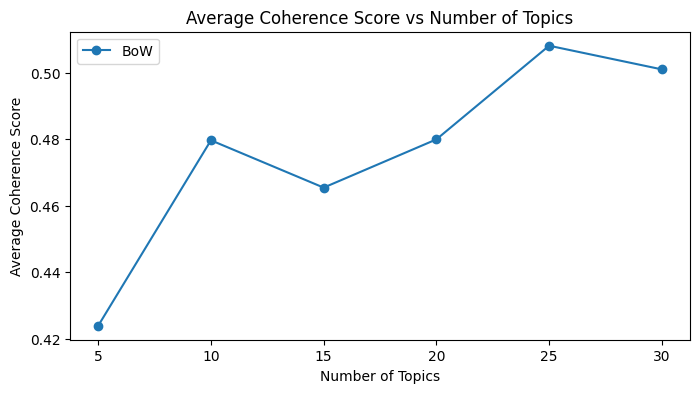

In [67]:
import matplotlib.pyplot as plt

# Group by 'Num_Topics' and calculate the average Coherence_BoW for each topic number
df_avg_per_coherence = df_per.groupby('Num_Topics').agg({
    'Coherence_BoW': 'mean'
}).reset_index()

# Plot Coherence Scores (average for each number of topics)
plt.figure(figsize=(8, 4))

# Plotting for BoW with average coherence scores
plt.plot(df_avg_per_coherence['Num_Topics'], df_avg_per_coherence['Coherence_BoW'], marker='o', linestyle='-', label='BoW')

# Labeling the axes and title
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Average Coherence Score vs Number of Topics')

# Add a legend
plt.legend()

# Display the plot
plt.show()

The "Average Coherence Score vs. Number of Topics" graph measures coherence scores across a range of topics from 5 to 30 using the Bag of Words (BoW) model. For five topics, the coherence score is 0.42; for 10 topics, it rises to about 0.48. After that, it slightly decreases to about 0.46 at 15 topics before rising once again to about 0.51 at 25 topics. At 30 topics, the score finally drops a little to around 0.50. As the number of topics rises, the coherence score varies. The greatest score achieved is around 25 topics, indicating that this is the ideal number of topics for the BoW model to obtain the best subject quality.

Hence, between 10 to 25 topics is ideal from this.

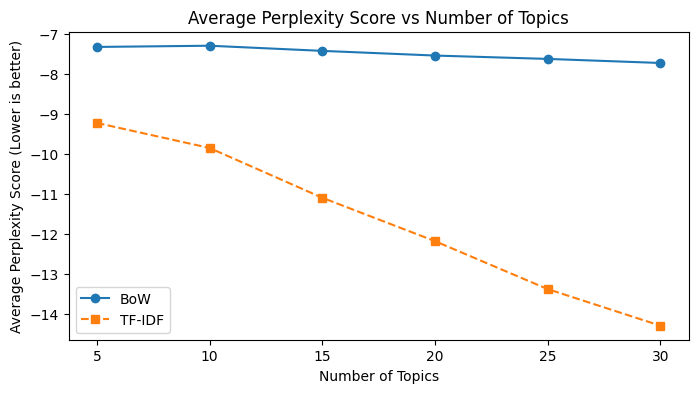

In [68]:
import matplotlib.pyplot as plt

# Group by 'Num_Topics' and calculate the average Perplexity for each topic number
df_avg_per_perplexity = df_results.groupby('Num_Topics').agg({
    'Perplexity_BoW': 'mean', 
    'Perplexity_TFIDF': 'mean'
}).reset_index()

# Plot Perplexity Scores (average for each number of topics)
plt.figure(figsize=(8, 4))

# Plotting for BoW and TF-IDF with average perplexity scores
plt.plot(df_avg_per_perplexity['Num_Topics'], df_avg_per_perplexity['Perplexity_BoW'], marker='o', linestyle='-', label='BoW')
plt.plot(df_avg_per_perplexity['Num_Topics'], df_avg_per_perplexity['Perplexity_TFIDF'], marker='s', linestyle='--', label='TF-IDF')

# Labeling the axes and title
plt.xlabel('Number of Topics')
plt.ylabel('Average Perplexity Score (Lower is better)')
plt.title('Average Perplexity Score vs Number of Topics')

# Add a legend
plt.legend()

# Display the plot
plt.show()

The "Average Perplexity Score vs. Number of Topics" graph contrasts the effectiveness of two models: Term Frequency-Inverse Document Frequency (TF-IDF) and Bag of Words (BoW) over a range of topics from 5 to 30. Plotting the average perplexity score on the y-axis shows that higher performance is indicated by lower scores. Across a range of topic counts, the BoW model, shown by the blue solid line with round markers, has comparatively consistent perplexity scores of about -7. The orange dashed line with square markers, which represents the TF-IDF model, on the other hand, shows a declining trend in perplexity scores as the number of subjects grows, beginning at about -9 and ending at about -14. According to this, the TF-IDF model outperforms the BoW model, exhibiting lower perplexity scores as the number of topics increases, indicating improved effectiveness in topic modeling

Looking at the bow line, as the perplexity decreases from 10 topics onwards the optimal numer is from 10 onwards.

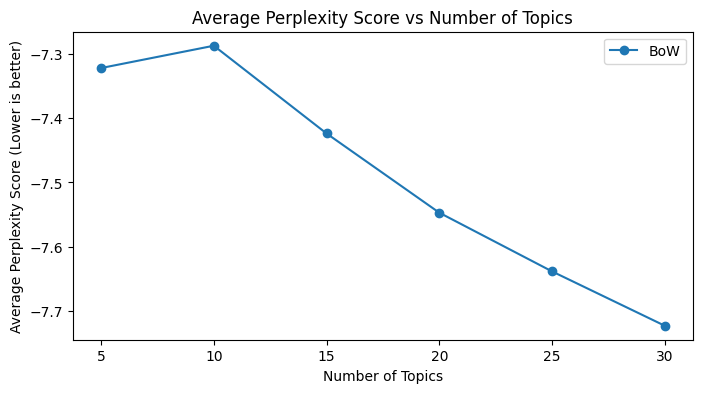

In [69]:
import matplotlib.pyplot as plt

# Group by 'Num_Topics' and calculate the average Perplexity for each topic number
df_avg_per_perplexity = df_per.groupby('Num_Topics').agg({
    'Perplexity_BoW': 'mean' 
}).reset_index()

# Plot Perplexity Scores with averaged values for each number of topics
plt.figure(figsize=(8, 4))

# Plotting for BoW with average perplexity score
plt.plot(df_avg_per_perplexity['Num_Topics'], df_avg_per_perplexity['Perplexity_BoW'], marker='o', linestyle='-', label='BoW')

# Labeling the axes and title
plt.xlabel('Number of Topics')
plt.ylabel('Average Perplexity Score (Lower is better)')
plt.title('Average Perplexity Score vs Number of Topics')

# Add a legend
plt.legend()

# Display the plot
plt.show()

Zooming into the BOW line without comparing the tfidf line: "Average Perplexity Score vs. Number of Topics" is a graph that examines how well the Bag of Words (BoW) model works. The y-axis shows the average perplexity score, where lower numbers indicate greater performance, and the x-axis shows the number of subjects, which ranges from 5 to 30. At five subjects, the BoW model's first perplexity score is around -7.3. The perplexity score gradually decreases to around -7.7 for 30 items after first increasing slightly to about -7.32 for 10 topics as the number of topics grows. According to this pattern, a bigger number of topics often yields a lower perplexity score, suggesting that the model performs better as the number of subjects increases.

hence, the optimum no. of topics to get a good perplexity is from 10-30.

### Grid Search for LDA Model Tuning based on Best No.of Topics

This lda_grid_search function performs hyperparameter tuning for an LDA (Latent Dirichlet Allocation) model to identify the best configuration for topic modeling. It systematically tests combinations of num_topics, alpha, and eta from the provided parameter lists. For each combination, it builds an LDA model using the build_lda_model function and evaluates its quality using the coherence score, a metric that measures the interpretability of the generated topics. The results, including the parameters, coherence score, and the model itself, are stored. The function tracks the best model based on the highest coherence score and returns this model along with its parameters and a record of all tested configurations. This ensures the selection of an optimal topic model configuration for the dataset.

from the graphs above, I  have come to a conlcusion that to get the best results the topic num should be between 10 and 25 hence I am doing to do some parameter tuning to evaluate some models between this topic number.

In [22]:
def lda_grid_search(doc_term_matrix, dictionary, texts, num_topics_range, alpha_list, eta_list):
    results = []
    best_coherence = -1
    best_perplexity = float('inf')  # Initialize with a high value
    best_num_topics_low = float('inf')  # Initialize with a high value for lowest topics
    best_num_topics_high = -1  # Initialize with a low value for highest topics
    
    best_model_coherence = None
    best_model_perplexity = None
    best_model_low_topics = None
    best_model_high_topics = None

    best_params_coherence = {}
    best_params_perplexity = {}
    best_params_low_topics = {}
    best_params_high_topics = {}

    # Loop over num_topics in the reduced range
    for num_topics in num_topics_range:
        for alpha in alpha_list:
            for eta in eta_list:
                print(f"Testing: num_topics={num_topics}, alpha={alpha}, eta={eta}")
                
                # Build the model with the current parameters
                model = build_lda_model(
                    doc_term_matrix=doc_term_matrix,
                    dictionary=dictionary,
                    num_topics=num_topics,
                    alpha=alpha,
                    eta=eta
                )
                
                # Calculate coherence score
                coherence_model = CoherenceModel(
                    model=model,
                    texts=texts,
                    dictionary=dictionary,
                    coherence='c_v'
                )
                coherence_score = coherence_model.get_coherence()
                print(f"Coherence Score: {coherence_score}")

                # Calculate perplexity score
                perplexity_score = model.log_perplexity(doc_term_matrix)
                print(f"Perplexity Score: {perplexity_score}")

                # Save the model and parameters
                results.append({
                    'num_topics': num_topics,
                    'alpha': alpha,
                    'eta': eta,
                    'coherence_score': coherence_score,
                    'perplexity_score': perplexity_score,
                    'model': model
                })

                # Update best model based on coherence score
                if coherence_score > best_coherence:
                    best_coherence = coherence_score
                    best_model_coherence = model
                    best_params_coherence = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta}

                # Update best model based on perplexity score
                if perplexity_score < best_perplexity:
                    best_perplexity = perplexity_score
                    best_model_perplexity = model
                    best_params_perplexity = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta}

                # Update best model based on lowest number of topics
                if num_topics < best_num_topics_low:
                    best_num_topics_low = num_topics
                    best_model_low_topics = model
                    best_params_low_topics = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta}

                # Update best model based on highest number of topics
                if num_topics > best_num_topics_high:
                    best_num_topics_high = num_topics
                    best_model_high_topics = model
                    best_params_high_topics = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta}

    return { 
        'best_model_coherence': best_model_coherence, 'best_params_coherence': best_params_coherence,
        'best_model_perplexity': best_model_perplexity, 'best_params_perplexity': best_params_perplexity,
        'best_model_low_topics': best_model_low_topics, 'best_params_low_topics': best_params_low_topics,
        'best_model_high_topics': best_model_high_topics, 'best_params_high_topics': best_params_high_topics,
        'results': results
    }

In [31]:
def build_lda_model(doc_term_matrix, dictionary, num_topics, alpha, eta):
    model = LdaModel(
        corpus=doc_term_matrix,
        num_topics=num_topics,
        id2word=dictionary,
        passes=15,  # More passes may improve quality but will take longer
        alpha=alpha,
        eta=eta
    )
    return model

In [32]:
# Define the reduced parameter grid
num_topics_range = [12, 15, 18]  # Reduced topics range
alpha_list = ['auto', 'symmetric', 0.1]  # 3 values for alpha
eta_list = ['auto', 0.01, 0.1]  # 3 values for eta

In [34]:
from gensim.models import LdaMulticore, LdaModel
# Run grid search with the reduced parameter grid
lda_results = lda_grid_search(
    doc_term_matrix=doc_term_matrix,
    dictionary=dictionary,
    texts=doc_clean,
    num_topics_range=num_topics_range,
    alpha_list=alpha_list,
    eta_list=eta_list
)

Testing: num_topics=12, alpha=auto, eta=auto
Coherence Score: 0.44564250904670527
Perplexity Score: -7.332209516851969
Testing: num_topics=12, alpha=auto, eta=0.01
Coherence Score: 0.48977751767256034
Perplexity Score: -9.167467718972802
Testing: num_topics=12, alpha=auto, eta=0.1
Coherence Score: 0.4904991888805959
Perplexity Score: -7.271829638943968
Testing: num_topics=12, alpha=symmetric, eta=auto
Coherence Score: 0.4570984789249794
Perplexity Score: -7.321103284265717
Testing: num_topics=12, alpha=symmetric, eta=0.01
Coherence Score: 0.46475795339991405
Perplexity Score: -9.205820682077036
Testing: num_topics=12, alpha=symmetric, eta=0.1
Coherence Score: 0.4758407110007103
Perplexity Score: -7.297874921576848
Testing: num_topics=12, alpha=0.1, eta=auto
Coherence Score: 0.47264267124512377
Perplexity Score: -7.332473870147441
Testing: num_topics=12, alpha=0.1, eta=0.01
Coherence Score: 0.46705856530786377
Perplexity Score: -9.205919729883236
Testing: num_topics=12, alpha=0.1, eta=0

In [35]:
# Retrieve the best models based on different criteria
best_model_coherence = lda_results['best_model_coherence']
best_model_perplexity = lda_results['best_model_perplexity']
best_model_low_topics = lda_results['best_model_low_topics']
best_model_high_topics = lda_results['best_model_high_topics']

In [36]:
# Print best parameters and coherence/perplexity scores for each model
print("Best Coherence Model Parameters:", lda_results['best_params_coherence'])
print("Best Perplexity Model Parameters:", lda_results['best_params_perplexity'])
print("Best Low Number of Topics Model Parameters:", lda_results['best_params_low_topics'])
print("Best High Number of Topics Model Parameters:", lda_results['best_params_high_topics'])

Best Coherence Model Parameters: {'num_topics': 15, 'alpha': 'auto', 'eta': 'auto'}
Best Perplexity Model Parameters: {'num_topics': 12, 'alpha': 0.1, 'eta': 0.01}
Best Low Number of Topics Model Parameters: {'num_topics': 12, 'alpha': 'auto', 'eta': 'auto'}
Best High Number of Topics Model Parameters: {'num_topics': 18, 'alpha': 'auto', 'eta': 'auto'}


In [37]:
# Print the topics for each of the models
print("\nTopics for Best Coherence Model:")
topics_coherence = best_model_coherence.print_topics(num_words=10)
for topic in topics_coherence:
    print(topic)


Topics for Best Coherence Model:
(0, '0.033*"clinical" + 0.024*"trial" + 0.022*"study" + 0.019*"research" + 0.016*"cancer" + 0.011*"support" + 0.009*"project" + 0.008*"application" + 0.008*"patient" + 0.007*"disease"')
(1, '0.015*"country" + 0.010*"support" + 0.009*"development" + 0.009*"people" + 0.008*"community" + 0.008*"service" + 0.008*"woman" + 0.007*"work" + 0.007*"access" + 0.007*"population"')
(2, '0.033*"service" + 0.027*"project" + 0.023*"bph" + 0.020*"package" + 0.017*"implementation" + 0.016*"grant" + 0.015*"consultant" + 0.015*"fund" + 0.014*"province" + 0.013*"eph"')
(3, '0.032*"tender" + 0.027*"contract" + 0.020*"programme" + 0.017*"criterion" + 0.014*"tenderer" + 0.012*"call" + 0.011*"project" + 0.010*"procedure" + 0.009*"month" + 0.008*"place"')
(4, '0.040*"research" + 0.024*"institution" + 0.014*"education" + 0.013*"application" + 0.013*"high" + 0.012*"government" + 0.011*"support" + 0.011*"project" + 0.011*"organization" + 0.010*"clinical"')
(5, '0.034*"bid" + 0.02

In [38]:
print("\nTopics for Best Perplexity Model:")
topics_perplexity = best_model_perplexity.print_topics(num_words=10)
for topic in topics_perplexity:
    print(topic)


Topics for Best Perplexity Model:
(0, '0.063*"date" + 0.041*"application" + 0.039*"number" + 0.025*"funding" + 0.021*"award" + 0.020*"opportunity" + 0.017*"information" + 0.017*"grant" + 0.016*"category" + 0.015*"activity"')
(1, '0.030*"cancer" + 0.017*"brain" + 0.012*"research" + 0.011*"cell" + 0.010*"human" + 0.010*"ad" + 0.008*"age" + 0.008*"initiative" + 0.008*"approach" + 0.007*"cognitive"')
(2, '0.022*"disease" + 0.019*"study" + 0.010*"research" + 0.010*"cell" + 0.008*"infection" + 0.008*"clinical" + 0.008*"immune" + 0.007*"mechanism" + 0.006*"human" + 0.005*"response"')
(3, '0.027*"clinical" + 0.018*"trial" + 0.016*"study" + 0.011*"support" + 0.010*"center" + 0.010*"network" + 0.010*"program" + 0.009*"research" + 0.009*"provide" + 0.008*"develop"')
(4, '0.043*"service" + 0.039*"project" + 0.018*"hospital" + 0.017*"consultant" + 0.015*"implementation" + 0.013*"equipment" + 0.012*"management" + 0.012*"medical" + 0.011*"system" + 0.011*"bph"')
(5, '0.019*"development" + 0.018*"pha

In [39]:
print("\nTopics for Best Low Number of Topics Model:")
topics_low_topics = best_model_low_topics.print_topics(num_words=10)
for topic in topics_low_topics:
    print(topic)


Topics for Best Low Number of Topics Model:
(0, '0.014*"research" + 0.014*"country" + 0.010*"programme" + 0.009*"development" + 0.009*"work" + 0.008*"global" + 0.007*"disease" + 0.007*"people" + 0.007*"support" + 0.006*"fund"')
(1, '0.017*"contract" + 0.013*"bid" + 0.013*"submit" + 0.011*"date" + 0.011*"procurement" + 0.010*"bidder" + 0.009*"document" + 0.009*"proposal" + 0.009*"tender" + 0.008*"information"')
(2, '0.055*"research" + 0.020*"program" + 0.016*"support" + 0.014*"institution" + 0.014*"cancer" + 0.013*"project" + 0.011*"clinical" + 0.011*"application" + 0.009*"training" + 0.008*"development"')
(3, '0.024*"center" + 0.018*"program" + 0.014*"network" + 0.011*"resource" + 0.011*"research" + 0.010*"disease" + 0.010*"develop" + 0.009*"community" + 0.009*"core" + 0.008*"fund"')
(4, '0.026*"child" + 0.017*"company" + 0.017*"phase" + 0.015*"year" + 0.011*"award" + 0.010*"sbir" + 0.010*"nutrition" + 0.009*"business" + 0.009*"sttr" + 0.009*"program"')
(5, '0.016*"institution" + 0.01

In [40]:
print("\nTopics for Best High Number of Topics Model:")
topics_high_topics = best_model_high_topics.print_topics(num_words=10)
for topic in topics_high_topics:
    print(topic)


Topics for Best High Number of Topics Model:
(0, '0.024*"disease" + 0.023*"study" + 0.022*"age" + 0.019*"genetic" + 0.014*"ad" + 0.011*"effect" + 0.011*"gene" + 0.009*"risk" + 0.009*"factor" + 0.008*"mechanism"')
(1, '0.016*"research" + 0.014*"cell" + 0.013*"brain" + 0.011*"human" + 0.009*"development" + 0.009*"cancer" + 0.009*"application" + 0.008*"study" + 0.007*"model" + 0.007*"system"')
(2, '0.017*"research" + 0.012*"treatment" + 0.011*"intervention" + 0.010*"population" + 0.009*"study" + 0.009*"prevention" + 0.009*"risk" + 0.008*"cancer" + 0.007*"outcome" + 0.007*"drug"')
(3, '0.019*"development" + 0.013*"country" + 0.012*"work" + 0.009*"organization" + 0.009*"public" + 0.008*"international" + 0.008*"government" + 0.008*"community" + 0.008*"people" + 0.007*"support"')
(4, '0.024*"care" + 0.022*"intervention" + 0.014*"phase" + 0.011*"application" + 0.011*"research" + 0.010*"company" + 0.009*"award" + 0.009*"year" + 0.008*"technology" + 0.008*"stage"')
(5, '0.035*"infection" + 0.03

After doing some parameter tuning, this is what I found:


Best Coherence Model Parameters: {'num_topics': 15, 'alpha': 'auto', 'eta': 'auto'}

Best Perplexity Model Parameters: {'num_topics': 12, 'alpha': 0.1, 'eta': 0.01}

Best Low Number of Topics Model Parameters: {'num_topics': 12, 'alpha': 'auto', 'eta': 'auto'}

Best High Number of Topics Model Parameters: {'num_topics': 18, 'alpha': 'auto', 'eta': 'auto'}


However after testing out some of the Models using the PLDAvis, it appeared that there were alot of overlaps especially in the num_topics = 18 and not alot of clear distinct between the topics (even though the models has good coherence and perplexity), so from 12 topics, I decided to decrease the num_topics from 12 to around 8-10 and test out the models.

### Test Models

After testing out the models with lower topic count and different parameters as well to see the affect, I found that topics which were more meaningful and had better distinctions. 

**Finding**

The model with num_topics=4 produced four very distinct topics. These topics were well-separated, had meaningful and coherent words, and were uniformly sized. This indicates that the dataset contains four overarching themes.

However, I will not use this model as the final one because the topics are too broad and general, leaving room for possible subtopics that are not captured.

In [42]:
import pyLDAvis.gensim as gensimvis

topic_num = 4  # Number of topics
word_num =  7  # Number of words per topic

lda_bow = LdaModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary, passes=20)
coherence_bow = CoherenceModel(model=lda_bow, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence()
perplexity_bow = lda_bow.log_perplexity(doc_term_matrix)
print(f"BoW Model - Topics: {topic_num}, Words: {word_num}, Coherence: {coherence_bow}, Perplexity: {perplexity_bow}")

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_bow, doc_term_matrix, dictionary)
pyLDAvis.display(vis_data) 

BoW Model - Topics: 4, Words: 7, Coherence: 0.4212861196901907, Perplexity: -7.36526546527386


In the data we can clearly see there are 4 commmon overarching topics. We will increrase the num of topics to find out the sub topics.

In [70]:
topic_num = 9  # Number of topics

lda_bow = LdaModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary, passes=20, random_state=42)
coherence_bow = CoherenceModel(model=lda_bow, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence()
perplexity_bow = lda_bow.log_perplexity(doc_term_matrix)
print(f"BoW Model - Topics: {topic_num}, Words: {word_num}, Coherence: {coherence_bow}, Perplexity: {perplexity_bow}")

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_bow, doc_term_matrix, dictionary)
pyLDAvis.display(vis_data)  

BoW Model - Topics: 9, Words: 7, Coherence: 0.4797657111987836, Perplexity: -7.279731266560745


Topics do seem meaningful however, there are some overlaps in the models. 

In [74]:
def display_lda_vis(model, corpus, dictionary):
    vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
    display(pyLDAvis.display(vis))  

print("Best Coherence Model:")
lda_coherence = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=15, alpha='auto', eta='auto', random_state=42)
display_lda_vis(lda_coherence, doc_term_matrix, dictionary)

Best Coherence Model:


some good distinct topics, however the there are a considerable number of small circles/topics which indicate these topics are probably less common in the dataset and there is also an overlap too in 2 of the topics making them not very distinct. some overlaps too.

In [75]:
print("Best Perplexity Model:")
lda_perplexity = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=12, alpha=0.1, eta=0.01, random_state=42)
display_lda_vis(lda_perplexity, doc_term_matrix, dictionary)

Best Perplexity Model:


After parameter tuning, this is the model with the highest perplexity. However the distance between the topics seems to be small than the other models and there are more overlaps too. The topics also seems to be of lower quality than the other models as seen from the words in each topic.

This shows that even the model with the highest perplexity after tuning maybe not be the best model.

In [76]:
def display_lda_vis(model, corpus, dictionary):
    vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
    display(pyLDAvis.display(vis))  
    
print("lowest no. of topics:")
lda_coherence = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=12, alpha='auto', eta='auto', random_state=42)
display_lda_vis(lda_coherence, doc_term_matrix, dictionary)

lowest no. of topics:


This is the model with the highest coherence, using the tuned parameters of alpha=auto, eta=auto. It shows relatively okay topcis however the quality of topics can still be more meaningful.

## Evaluation
Perform the necessary steps and explain the rationale taken here.



After doing parameter tuning and analysing various models through looking at their coherence, perpleixty and how meaningful the words in the topics are and how distinct they are from each other, the chosen num_topics = 10.

In [50]:
num_topics = 10
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

### Visualization

In [51]:
pyLDAvis.enable_notebook()

print("Visualizing Bag of Words (Doc2Bow) LDA Model...")
vis_doc2bow = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis_doc2bow) 

Visualizing Bag of Words (Doc2Bow) LDA Model...


### Perplexity and Coherence

In [52]:
# Bag of Words Perplexity
print("\nBag of Words (Doc2Bow) Model Perplexity:")
print(lda_model.log_perplexity(doc_term_matrix))

# Bag of Words Coherence
print("\nBag of Words (Doc2Bow) Model Coherence:")
coherence_doc2bow = gensim.models.CoherenceModel(
    model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v'
)
print("Coherence Score:", coherence_doc2bow.get_coherence())


Bag of Words (Doc2Bow) Model Perplexity:
-7.293039468787575

Bag of Words (Doc2Bow) Model Coherence:
Coherence Score: 0.5005294242684393


From the LDA models's perplexity, the perplexity is low and negative which shows the model is performing relatively well. However as compared to the other models it could still be lower which tells us that the model can be improved. 

Compared to the coherence of the previously tuned models, this model seems to hve relatively good coherence which could mean that the topics generated are somewhat more coherent, distinguishable and meaningful. 

Overal even though the values can still be improved and are slightly lower than the other models, this model was chosen due to the better interpretability and quality of the topics. 

### Topic Details

In [53]:
# Bag of Words Topics
print("\nBag of Words (Doc2Bow) Model Topics:")
pprint(lda_model.print_topics(num_topics=topic_num, num_words=word_num))


Bag of Words (Doc2Bow) Model Topics:
[(5,
  '0.021*"woman" + 0.012*"infection" + 0.012*"alcohol" + 0.010*"child" + '
  '0.009*"pregnancy" + 0.008*"study" + 0.008*"maternal"'),
 (9,
  '0.018*"clinical" + 0.016*"application" + 0.016*"institution" + '
  '0.015*"trial" + 0.012*"project" + 0.012*"government" + 0.012*"award"'),
 (8,
  '0.010*"support" + 0.010*"develop" + 0.009*"program" + 0.008*"disease" + '
  '0.007*"clinical" + 0.007*"provide" + 0.007*"network"'),
 (3,
  '0.016*"supply" + 0.012*"medical" + 0.011*"service" + 0.011*"project" + '
  '0.010*"equipment" + 0.010*"water" + 0.010*"provide"'),
 (4,
  '0.024*"contract" + 0.020*"service" + 0.012*"project" + 0.010*"bidder" + '
  '0.010*"tender" + 0.009*"procurement" + 0.008*"bid"'),
 (0,
  '0.022*"proposal" + 0.019*"submit" + 0.018*"date" + 0.014*"bid" + '
  '0.013*"undp" + 0.012*"number" + 0.011*"section"'),
 (7,
  '0.019*"cell" + 0.013*"human" + 0.010*"brain" + 0.010*"disease" + '
  '0.009*"research" + 0.009*"model" + 0.009*"study"'

### Analysis of the Topics and Topic Models Generated

The topics generated seem to align well with the context of SG #3 Good Health and Well-Being which aims to ensure health and well-being for all incliding the bold commitment to end all epidemics by 2030. It also seeks to achieve universal health coverage and provide safe safe vaccines and medication for all. The dataset seems to contain text from various sources. 

The topics generate identified by the model produce meaningful terms related to healthcare like "care", "treatment", "medical", "research", and "clinical" uncovering the potential themes like healthcare services, clinical trials, disease prevention and materal health.

The weightage of the topics further highlights that the model has effectively captured and quantified the the importance of these health related themes. 

Again, the reasonable perplexity and coherence score of 0.5 shows that the model performs well in generating relavent topics, that are both coherent, generate good quality topics and are relavent to the issue of critical healthcare efforts aligned with SDG's goals.

### Key Themes and Descriptions Identified from the Model

## Topic Modeling Results

### **Topic 0: Proposal & Application**

**Main Terms:**
- proposal (weight: 0.022)
- submit (weight: 0.019)
- date (weight: 0.018)
- bid (weight: 0.015)
- UNDP (weight: 0.015)
- document (weight: 0.014)
- application (weight: 0.012)
- request (weight: 0.009)
- follow (weight: 0.008)

This revolves around the formal processes of submitting proposals and applications, possibly related to the United Nations Development Programme (UNDP). "proposal", "sUbmit", and "date" are important terms which in define the procedural aspects of bid submission and deadline management. The inclusion of "UNDP" (after searching it stands for United Nations Development Programme) highlights that that this process is associated with international development projects and initiatives led by UNDP.

---

### **Topic 1: Medical Research & Intervention**

**Main Terms:**
- intervention (weight: 0.018)
- study (weight: 0.015)
- research (weight: 0.014)
- care (weight: 0.013)
- treatment (weight: 0.012)
- patient (weight: 0.010)
- trial (weight: 0.009)
- disease (weight: 0.008)
- outcome (weight: 0.007)

This topic is strongly associated with clinical research and interventions. "Intervention" and "study" hold significant importance, as they are central to clinical research projects. "Research" further highlights this focus, while terms like "patient" and "disease" are also relevant but with lower weights.

---

### **Topic 2: Research Support & Development**

**Main Terms:**
- research (weight: 0.062)
- program (weight: 0.018)
- support (weight: 0.014)
- clinical (weight: 0.012)
- institution (weight: 0.010)
- application (weight: 0.009)
- project (weight: 0.008)
- education (weight: 0.007)
- career (weight: 0.006)

This topic highlights the need for research support, funding, and academic development. "research", "program", and "support" are the heaviest weighted, hinting to me that that this topic focuses on the infrastructure around research projects and development within academic institutions.

---

### **Topic 3: Supply & Medical Services**

**Main Terms:**
- supply (weight: 0.016)
- medical (weight: 0.012)
- service (weight: 0.011)
- project (weight: 0.010)
- equipment (weight: 0.009)
- water (weight: 0.008)
- hospital (weight: 0.007)
- product (weight: 0.006)
- facility (weight: 0.005)

This topic is about the provision of medical supplies and services. Terms like "supply" and "medical" define the core of this topic. The term "service" also holds considerable amount of weight, suggesting that this topic is about healthcare service systems.

---

### **Topic 4: Contract & Procurement**

**Main Terms:**
- contract (weight: 0.024)
- service (weight: 0.020)
- project (weight: 0.012)
- bidder (weight: 0.010)
- tender (weight: 0.009)
- procurement (weight: 0.009)
- consultant (weight: 0.008)
- implementation (weight: 0.006)
- submit (weight: 0.005)

This topic appears to be related to procurement and tendering processes. "Contract" takes the highest weight, highlighting the formal nature of agreements in this domain. Other important terms are "service", "bidder", and "procurement" for competitive bidding.

---

### **Topic 5: Women's Health & Maternal Issues**

**Main Terms:**
- woman (weight: 0.021)
- infection (weight: 0.012)
- alcohol (weight: 0.010)
- pregnancy (weight: 0.009)
- child (weight: 0.008)
- study (weight: 0.007)
- maternal (weight: 0.006)
- risk (weight: 0.006)
- obesity (weight: 0.005)

The focus of this topic is about women’s health, in particular, maternal and child health. The highest weighted term, "woman", is the centre of this topic with the heighest weightage of 0.021, followed by "infection" and "pregnancy", which are key to the health conditions discussed.

---

### **Topic 6: Child & Community Services**

**Main Terms:**
- service (weight: 0.016)
- country (weight: 0.012)
- support (weight: 0.011)
- child (weight: 0.010)
- community (weight: 0.009)
- improve (weight: 0.008)
- care (weight: 0.007)
- development (weight: 0.006)
- program (weight: 0.005)

This topic revolves around social services and community support for children. The weight of "service" shows its centrality with the heighest weight of 0.016, while terms like "country" and "support" reinforce that the topic is about public services for children and families.

---

### **Topic 7: Disease Research & Cellular Studies**

**Main Terms:**
- cell (weight: 0.019)
- human (weight: 0.013)
- brain (weight: 0.010)
- disease (weight: 0.009)
- research (weight: 0.008)
- immune (weight: 0.008)
- cancer (weight: 0.007)
- tissue (weight: 0.006)
- mechanism (weight: 0.005)

This topic is focued on disease research at the cellular and molecular levels. The weight of "cell" (highest weightage of 0.019) indicates its importance in this field, while terms like "human" and "brain" suggest a potential focus on biomedical research.

---

### **Topic 8: Disease Support & Clinical Development**

**Main Terms:**
- support (weight: 0.010)
- develop (weight: 0.010)
- disease (weight: 0.009)
- clinical (weight: 0.007)
- network (weight: 0.006)
- resource (weight: 0.005)
- research (weight: 0.005)
- vaccine (weight: 0.004)

This topic is about clinical development and disease support networks. "Support" and "develop" have high weights, indicating a focus on building systems to aid clinical research and patient support.

---

### **Topic 9: Clinical Trials & Institutional Projects**

**Main Terms:**
- clinical (weight: 0.018)
- application (weight: 0.016)
- institution (weight: 0.016)
- trial (weight: 0.015)
- project (weight: 0.012)
- government (weight: 0.012)
- award (weight: 0.011)
- research (weight: 0.011)

This topic revolves around academic and governmental aspects of clinical trials. "clinical" and "application" dominate (with high weights), showing an emphasis on formal clinical trials and research proposals.

### Topic Distributions for Documents

In [54]:
filenames = [f"Doc_{i+1}" for i in range(len(doc_clean))] 

This code uses the BOW model and the LDA model to analyze a set of documents, extract their topic distributions, and identify the most prominent topic for each document.

In [56]:
for topic_id, docs in dic_topic_doc_bow.items():
    print(f"Topic {topic_id}: {len(docs)} documents")

Topic 6: 1257 documents
Topic 2: 267 documents
Topic 0: 459 documents
Topic 9: 246 documents
Topic 1: 282 documents
Topic 7: 183 documents
Topic 8: 370 documents
Topic 5: 160 documents
Topic 3: 453 documents
Topic 4: 316 documents


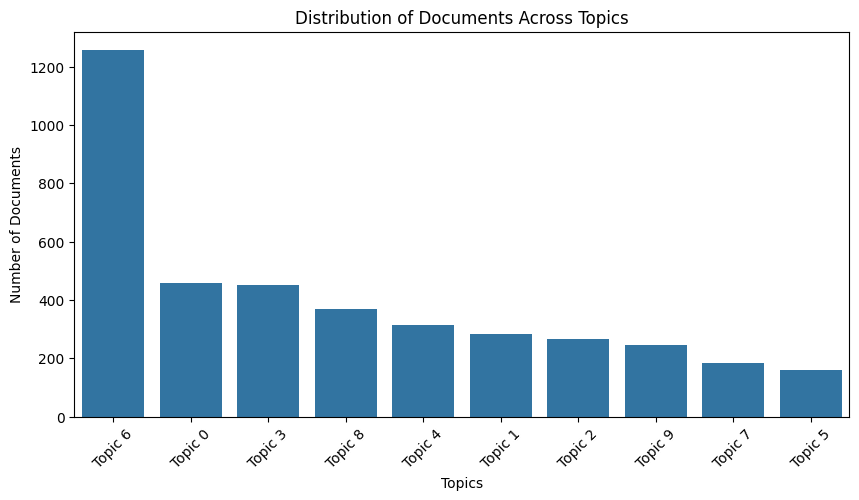

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count how many documents belong to each dominant topic
topic_counts = {topic: len(docs) for topic, docs in dic_topic_doc_bow.items()}

# Sort topics by frequency
sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

# Plot
plt.figure(figsize=(10, 5))
barplot = sns.barplot(x=[f"Topic {t[0]}" for t in sorted_topics], 
                      y=[t[1] for t in sorted_topics])

# Manually set labels for the legend
for i, patch in enumerate(barplot.patches):
    patch.set_label(f"Topic {sorted_topics[i][0]}")

plt.xlabel("Topics")
plt.ylabel("Number of Documents")
plt.title("Distribution of Documents Across Topics")
plt.xticks(rotation=45)
plt.show()

Topic 6 is the most prevalent, with 1253 documents, indicating it covers a central theme (Child and Community Servies) in the dataset. Other topics like Topic 0 (458 documents) and Topic 3 (454 documents) are also significant, while topics such as Topic 7 (183 documents) and Topic 5 (158 documents) are less frequently discussed.

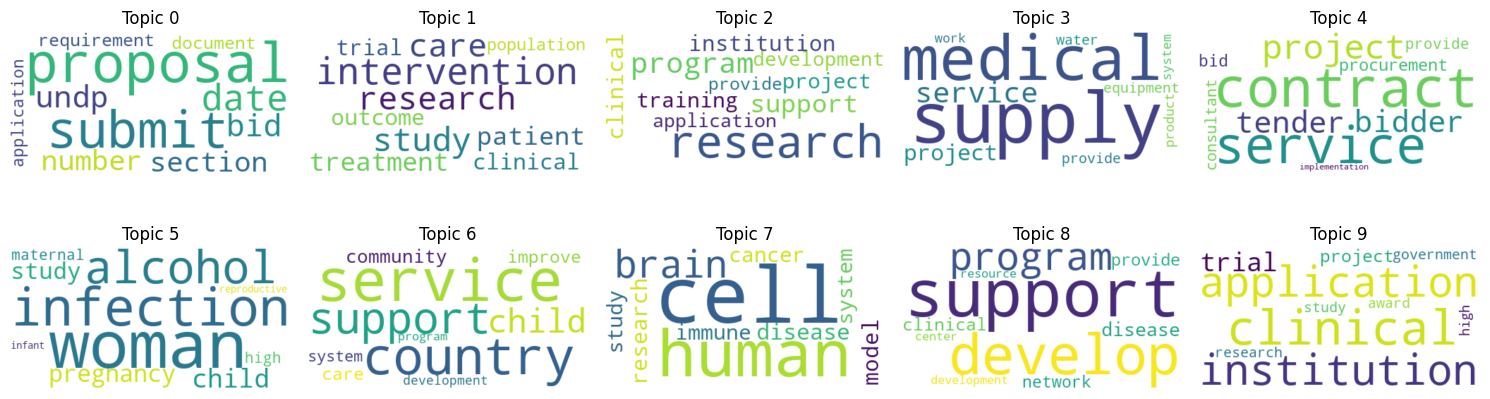

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get topic keywords from LDA model
topics = lda_model.show_topics(num_topics=10, num_words=10, formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 5))  # Adjust for 10 topics

for i, ax in enumerate(axes.flatten()[:10]):  # Ensure it doesn't exceed available topics
    topic_words = dict(topics[i][1])  # Extract topic words
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Topic {i}")

plt.tight_layout()
plt.show()

This shows the words in each topic. The size of the words represent the higher the importance/frequency which shows the key themes and aided me in creating topic titles for each topic.

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.